In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
from mppi.Utilities import Constants as Const
from mppi.Utilities import LatticeUtils as LL
import matplotlib.pyplot as plt
import numpy as np
import os, yaml

In [ ]:
# RunRules for local computations
mpi = 4
omp = 2

rr = C.RunRules(omp_num_threads=omp,mpi=mpi)
code = C.QeCalculator(rr)
code.global_options()

In [3]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16
cpus_per_task=2
omp_num_threads=2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',time='11:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.QeCalculator(rr,activate_BeeOND=True) #,skip=False,clean_restart=False
code.global_options()

Initialize a QuantumESPRESSO calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 16,
 'cpus_per_task': 2,
 'omp_num_threads': 2,
 'gpus_per_node': None,
 'memory': '125000',
 'time': '11:59:00',
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'pw.x',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True}

In [3]:
# RunRules for m100
nodes = 1
ntasks_per_node = 4
cpus_per_task=32
omp_num_threads=8
gpus_per_node=4
pe=8

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='m100_usr_prod',
                account='IscrC_PrExIn',
                memory='120GB',time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gpus_per_node=gpus_per_node,pe=pe,
                map_by='socket',rank_by='core')
code = C.QeCalculator(rr)
code.global_options()

Initialize a QuantumESPRESSO calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 4,
 'cpus_per_task': 32,
 'omp_num_threads': 8,
 'gpus_per_node': 4,
 'memory': '120GB',
 'time': '23:59:00',
 'partition': 'm100_usr_prod',
 'account': 'IscrC_PrExIn',
 'qos': None,
 'map_by': 'socket',
 'pe': 8,
 'rank_by': 'core',
 'executable': 'pw.x',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True}

# DFT analysis of the Stanene monolayer

This notebook contains the DFT analysis of the 2D Stanene monolayer performed with QuantumESPRESSO

## Lattice properties and atomic positions

We use the lattice configuration adopted by QuantumESPRESSO in the ibrav=4 case.

The basis vector of the (direct) lattice are defined as
$$
a_1 = a_{lat}(1,0,0) \, ,\quad a_2 = a_{lat}(\frac{-1}{2},\frac{\sqrt{3}}{2},0) \, ,\quad
a_3 = a_{lat}(0,0,\frac{c}{a_{lat}})
$$
so that $c$ vacuum space between two replica of the sheets, expressed in the same units as $a_{lat}$.
We also observe that $\textrm{celldm(3)}=c/a_{lat}$, so it expresses the vacuum distance in terms of 
$a_{lat}$.

The cartesian component of the reciprocal lattice vectors (in units of $2\pi/a_{alat}$) are given by:

$$
b_1 = (1,\frac{1}{\sqrt{3}}) \, ,\quad b_2 = (0,\frac{2}{\sqrt{3}},0) \, ,\quad
b_3 = (0,0,\frac{a}{c})
$$
The reciprocal vectors have module $2/\sqrt{3}$.

The cartesian coordinates of the high symmetry points of the reciprocal lattice (in units of $2\pi/a_{alat}$) 
can be determined by performing the construction of the Brillouin zone: we find the points on at the half of
the $b_1$ and $b_2$ vectors and build the path moving perpendicularly to the basis vector directions.
The $M$ point (at the middle of the hexagon face) and the $K$ point (the edge point) are given by:
$$
M = (\frac{1}{2},\frac{1}{2\sqrt{3}}) \, \quad
K = (\frac{2}{3},0) 
$$
Moreover we write the coordinates of the symmetry related K' point (which corresponds to another edge of the hexagon)
and M' point (middle point of the top edge of the hexagon): 
$$
K' = (\frac{1}{3},\frac{1}{\sqrt{3}}) \, \quad
M' = (0,\frac{1}{\sqrt{3}}) 
$$
These points, together with $\Gamma$ define the IBZ edges in the representation of QuantumESPRESSO.

In cartesian coordinates the atomic positions read
$$
Sn_1 = a_{lat}(0,\frac{1}{\sqrt{3}},\delta) \, \qquad Sn_2 = a_{lat}(\frac{1}{2},\frac{1}{2\sqrt{3}},-\delta)
$$
where $\delta$ is the buckling of the Sn atoms in units of $a_{lat}$.

## GS Analysis

We analyze the electronic configuration of the GS.

In [4]:
pseudo_dir = '../pseudos'
Sn_pseudo = 'Sn.rel-pbe-dn-kjpaw_psl.1.0.0.UPF'

We use the following initial guess for the GS parameters:

In [5]:
alat = 8.8344575 # in a.u. (Bohr)
c = 30.0 # vacuum distance in a.u. 
celldm3 = c/alat # in units of alat
delta = 0.09159777 # in units of alat
print(celldm3)

3.3957942522220526


Atomic positions in cartesian and crystal coordinates and lattice vectors

In [8]:
# cartesian coordinates expressed in units of alat
Sn1 = np.array([0,1./np.sqrt(3.),delta])
Sn2 = np.array([1./2.,1./(2*np.sqrt(3.)),-delta])

lattice = alat*np.array([[1,0,0],[-1./2.,np.sqrt(3)/2.,0],[0,0,celldm3]])
atoms = [['Sn',alat*Sn1],['Sn',alat*Sn2]]

We plot the lattice in xy and xz directions

In [7]:
positions = LL.build_lattice(lattice,atoms,8,8,1)
#positions

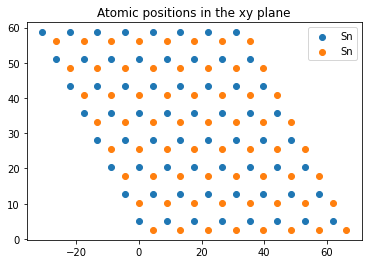

In [8]:
for pos in positions:
    plt.scatter(pos[1],pos[2],label=pos[0])
plt.title('Atomic positions in the xy plane',size=12)
plt.legend()

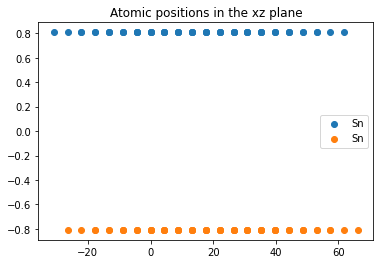

In [9]:
for pos in positions:
    plt.scatter(pos[1],pos[3],label=pos[0])
plt.title('Atomic positions in the xz plane',size=12)
plt.legend()

### Convergence procedure on the $k$-points sampling and of energy cutoff of the wave functions

We perform a set of calculations in functions of the number of k-points and of the energy cutoff and we find
the converged values using the total ground state energy, the gap at $K$ and the gap at $\Gamma$ as control quantities.

In [12]:
run_dir = 'DFT_analysis'

We build the basic elements of the input 

In [13]:
inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_num_bnds(30)
inp.set_pseudo_dir(pseudo_dir=pseudo_dir)
inp.set_spinorbit()
inp.add_atom(atom='Sn',pseudo_name=Sn_pseudo,mass=118.71)
inp.set_atoms_number(2)
inp.set_atomic_positions([['Sn',Sn1],['Sn',Sn2]],type='alat')
inp.set_lattice(ibrav=4,celldm1=alat,celldm3=celldm3)
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'pwscf'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 30,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '1',
  'nat': '2',
  'ibrav': 4,
  'celldm(1)': 8.8344575,
  'celldm(3)': 3.3957942522220526},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Sn': [118.71, 'Sn.rel-pbe-dn-kjpaw_psl.1.0.0.UPF']},
 'atomic_positions': {'type': 'alat',
  'values': [['Sn', array([0.        , 0.57735027, 0.09159777])],
   ['Sn', array([ 0.5       ,  0.28867513, -0.09159777])]]},
 'kpoints': {},
 'cell_parameters': {}}

In [11]:
kvalues = [12,15,18,21]
ecut = [60,80,100,120]

In [13]:
study = D.Dataset(run_dir=run_dir,num_tasks=8)

for k in kvalues:
    for e in ecut:
        idd = {'ecut' : e, 'k' : k}
        inp.set_prefix(D.name_from_id(idd))
        inp.set_kpoints(type='automatic',points=[k,k,1])
        inp.set_energy_cutoff(e)
        study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 8 parallel tasks


In [14]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] with the parallel task_groups [[0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15]] 

Run the task [0, 1, 2, 3, 4, 5, 6, 7] 
Skip the run of ecut_60-k_12
Skip the run of ecut_100-k_12
Skip the run of ecut_80-k_12
Skip the run ofSkip the run of Skip the run of ecut_100-k_15ecut_120-k_12

Skip the run of ecut_80-k_15 
ecut_120-k_15
Skip the run of ecut_60-k_15
Task [0, 1, 2, 3, 4, 5, 6, 7] ended 
 
Run the task [8, 9, 10, 11, 12, 13, 14, 15] 
Skip the run ofSkip the run ofSkip the run ofSkip the run of    ecut_80-k_18ecut_100-k_18ecut_120-k_18ecut_60-k_18



Skip the run ofSkip the run of  ecut_100-k_21ecut_60-k_21

Skip the run ofSkip the run of  ecut_120-k_21ecut_80-k_21

Task [8, 9, 10, 11, 12, 13, 14, 15] ended 
 


12 [-442.9038217317394, -442.9085294296453, -442.9090158801303, -442.9093300543862]
15 [-442.903875993292, -442.9085805287059, -442.9090666778314, -442.9093811331618]
18 [-442.9038937151973, -442.9086000193903, -442.9090862533626, -442.9094006049927]
21 [-442.9039009032967, -442.90860868272, -442.9090948230916, -442.909409259727]


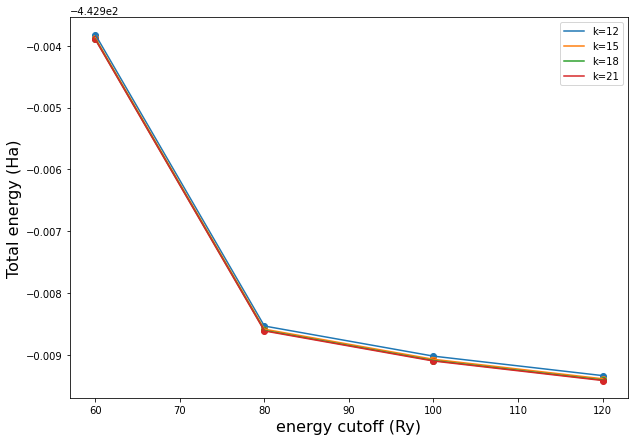

In [15]:
plt.figure(figsize=(10,7))
plt.xlabel('energy cutoff (Ry)',size=16)
plt.ylabel('Total energy (Ha)',size=16)
for k in kvalues:
    energy =study.fetch_results(id={'k':k},attribute='energy')
    print(k,energy)
    plt.plot(ecut,energy,label='k=%s'%k)
    plt.scatter(ecut,energy)
plt.legend()

12 [0.07731183571115463, 0.077278356225561, 0.07727553126645925, 0.0772709086967196]
15 [0.07732859784389112, 0.07729605361285508, 0.07729114103964974, 0.07728897924905764]
18 [0.0773374801202027, 0.07730160195138502, 0.07729999022762835, 0.07729720932078177]
21 [0.07734251467772268, 0.07730507941275677, 0.07730235865540314, 0.07730071415684847]
12 [0.2722971640212686, 0.2733492701082916, 0.27391836060164465, 0.27405310131620797]
15 [0.27276104584510774, 0.273819446828665, 0.2743654957084778, 0.2745315267224502]
18 [0.27300095378844236, 0.274045226593181, 0.27460819414273185, 0.27477899006227235]
21 [0.27311934723114706, 0.27416540929864963, 0.2747262758599138, 0.27486729835199464]


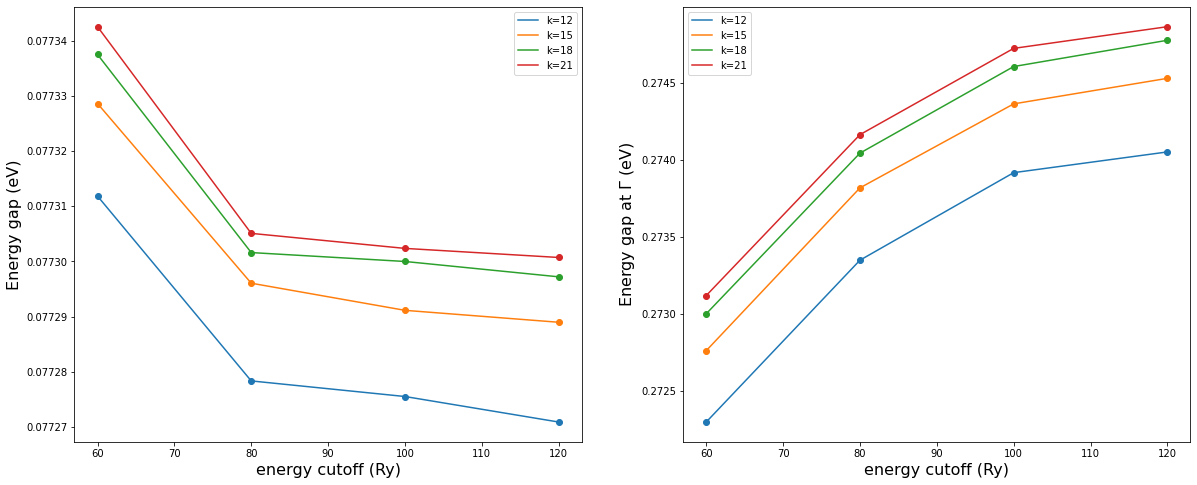

In [16]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20, 8))

ax[0].set_xlabel('energy cutoff (Ry)',size=16)
ax[0].set_ylabel('Energy gap (eV)',size=16)
for k in kvalues:
    data = study.fetch_results(id={'k':k})    
    gap = [d.get_gap(verbose=False)['direct_gap'] for d in data]
    print(k,gap)
    ax[0].plot(ecut,gap,label='k=%s'%k)
    ax[0].scatter(ecut,gap)
ax[0].legend()
ax[1].set_xlabel('energy cutoff (Ry)',size=16)
ax[1].set_ylabel('Energy gap at $\Gamma$ (eV)',size=16)
for k in kvalues:
    data = study.fetch_results(id={'k':k})    
    gap_gamma = [d.get_evals()[0][28]- d.get_evals()[0][27] for d in data]
    print(k,gap_gamma)
    ax[1].plot(ecut,gap_gamma,label='k=%s'%k)
    ax[1].scatter(ecut,gap_gamma)
ax[1].legend()

On the basis of these results we choose

In [17]:
ecut_conv = 80 # energy cutoff on the wavefunction (Ry)
kpoints_conv = [15,15,1]

In [18]:
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(type='automatic',points=kpoints_conv)

### Calculation of the equilibrium lattice constants and buckling parameter

We determine the equiblrium values of the lattice constant and of the buckling parameter by minimizing
the GS energy

In [19]:
alat_range = 2 # alat percentage variation
alat_num = 5 # number of calculations
delta_range = 2 # buckling percentage variation
delta_num = 5 # number of calculations

alat_span = np.linspace(-alat_range/2,alat_range/2,alat_num)

delta_span = np.linspace(-delta_range/2,delta_range/2,delta_num)

alat_span, delta_span

(array([-1. , -0.5,  0. ,  0.5,  1. ]), array([-1. , -0.5,  0. ,  0.5,  1. ]))

In [20]:
study = D.Dataset(run_dir=run_dir,num_tasks=10)

for a_span in alat_span:
    for d_span in delta_span:
        a = alat*(1+a_span/100)
        d = delta*(1+d_span/100)
        
        Sn1 = np.array([0,1./np.sqrt(3.),d])
        Sn2 = np.array([1./2.,1./(2*np.sqrt(3.)),-d])
        idd = {'alat' : a_span, 'delta' : d_span}
        inp.set_prefix(D.name_from_id(idd))
        inp.set_atomic_positions([['Sn',Sn1],['Sn',Sn2]],type='alat')
        inp.set_lattice(ibrav=4,celldm1=a,celldm3=c/a)
        study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_get_energy)
#study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 10 parallel tasks


In [21]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24] with the parallel task_groups [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [20, 21, 22, 23, 24]] 

Run the task [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
Skip the run of Skip the run ofalat_-0.5-delta_-0.5Skip the run ofSkip the run ofSkip the run ofSkip the run of
 Skip the run of    alat_-0.5-delta_0.0alat_-1.0-delta_-0.5alat_-1.0-delta_0.0Skip the run ofalat_-1.0-delta_1.0alat_-1.0-delta_0.5 
Skip the run of



alat_-0.5-delta_0.5 
alat_-1.0-delta_-1.0
 alat_-0.5-delta_-1.0
Skip the run of alat_-0.5-delta_1.0
Task [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ended 
 
Run the task [10, 11, 12, 13, 14, 15, 16, 17, 18, 19] 
Skip the run of alat_0.0-delta_-1.0
Skip the run of alat_0.0-delta_-0.5Skip the run of
Skip the run of  alat_0.0-delta_0.0alat_0.0-delta_1.0Skip the run of

 alat_0.5-delta_-1.0
Skip the run ofSkip the run of  alat_0.5-delta_-0.5alat_0.0-delta_0.5

Skip

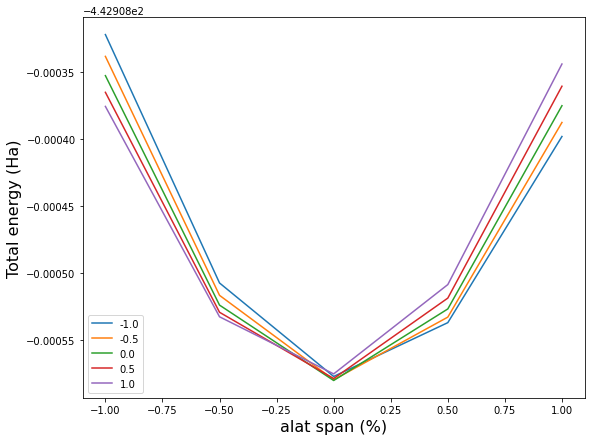

In [22]:
plt.figure(figsize=(9,7))
plt.xlabel('alat span (%)',size=16)
plt.ylabel('Total energy (Ha)',size=16)
for d_span in delta_span:
    energy =study.fetch_results(id={'delta':d_span})
    plt.plot(alat_span,energy,label=d_span)
plt.legend()

To find the optimal alat parameter we perform a quadratic fit of data (for delta=0)

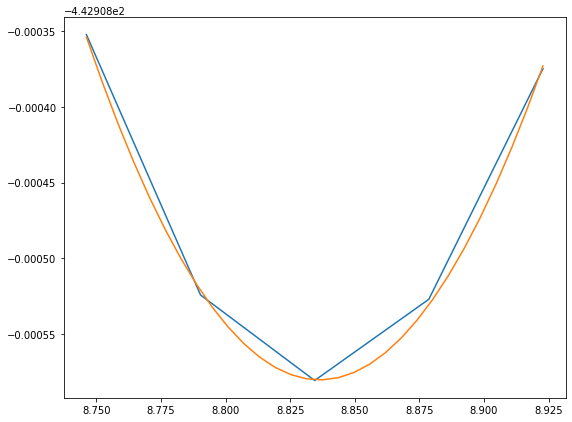

In [23]:
plt.figure(figsize=(9,7))
y =study.fetch_results(id={'delta':0.})
x = [alat*(1+a/100) for a in alat_span]
x_fit = np.linspace(x[0],x[-1],30)
coeffs = np.polyfit(x,y,2)
y_fit = [coeffs[0]*xx**2+coeffs[1]*xx+coeffs[2] for xx in x_fit]
plt.plot(x,y)
plt.plot(x_fit,y_fit)

In [24]:
x_eq = -coeffs[1]/(2*coeffs[0])
x_eq

8.836410180981327

In the same way the optimal buckling is 

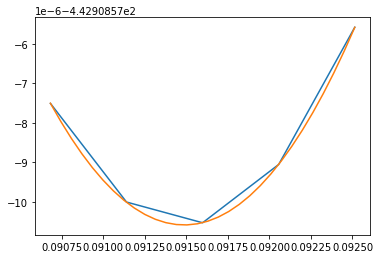

In [25]:
y =study.fetch_results(id={'alat':0.})
x = [delta*(1+a/100) for a in delta_span]
x_fit = np.linspace(x[0],x[-1],30)
coeffs = np.polyfit(x,y,2)
y_fit = [coeffs[0]*xx**2+coeffs[1]*xx+coeffs[2] for xx in x_fit]
plt.plot(x,y)
plt.plot(x_fit,y_fit)

In [26]:
x_eq = -coeffs[1]/(2*coeffs[0])
x_eq

0.09148726138454526

On the basis of this analysis we set

In [27]:
alat_conv =  8.83641018 # in a.u. (Bohr)
delta_conv = 0.09148726 # in units of alat

### Convergence analysis on the spacing between the sheets replica

We perform a convergence study on the vacuum distance parameter.

In [51]:
c_values = [5,10,15,20,25,30,40,50] # in a.u.
Sn1 = np.array([0,1./np.sqrt(3.),delta_conv])
Sn2 = np.array([1./2.,1./(2*np.sqrt(3.)),-delta_conv])

study = D.Dataset(run_dir=run_dir,num_tasks=2)

for cval in c_values:
    idd = {'vacuum_value' : cval}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_atomic_positions([['Sn',Sn1],['Sn',Sn2]],type='alat')
    inp.set_lattice(ibrav=4,celldm1=alat_conv,celldm3=cval/alat_conv)
    study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 2 parallel tasks


In [52]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'DFT_analysis',
 'num_tasks': 2,
 'verbose': True,
 'input': {'control': {'calculation': "'scf'",
   'verbosity': "'high'",
   'prefix': "'vacuum_value_5'",
   'outdir': "'./'",
   'pseudo_dir': "'../pseudos'"},
  'system': {'force_symmorphic': '.true.',
   'nbnd': 30,
   'lspinorb': '.true.',
   'noncolin': '.true.',
   'ntyp': '1',
   'nat': '2',
   'ibrav': 4,
   'celldm(1)': 8.83641018,
   'celldm(3)': 0.5658406409558503,
   'ecutwfc': 80},
  'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
  'ions': {},
  'cell': {},
  'atomic_species': {'Sn': [118.71, 'Sn.rel-pbe-dn-kjpaw_psl.1.0.0.UPF']},
  'atomic_positions': {'type': 'alat',
   'values': [['Sn', array([0.        , 0.57735027, 0.09148726])],
    ['Sn', array([ 0.5       ,  0.28867513, -0.09148726])]]},
  'kpoints': {'type': 'automatic', 'values': ([15, 15, 1], [0.0, 0.0, 0.0])},
  'cell_parameters': {}},
 'name': 'vacuum_value_5'}

In [53]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7] with the parallel task_groups [[0, 1], [2, 3], [4, 5], [6, 7]] 

Run the task [0, 1] 
run command: mpirun -np 16 pw.x -inp vacuum_value_5.in > vacuum_value_5.logSkip the run of 
vacuum_value_10
slurm submit:  cd DFT_analysis ; sbatch job_vacuum_value_5.sh
computation vacuum_value_5 is running...
computation vacuum_value_5 ended
Task [0, 1] ended 
 
Run the task [2, 3] 
run command: mpirun -np 16 pw.x -inp vacuum_value_15.in > vacuum_value_15.logSkip the run of
 vacuum_value_20slurm submit: 
 cd DFT_analysis ; sbatch job_vacuum_value_15.sh
computation vacuum_value_15 is running...
computation vacuum_value_15 ended
Task [2, 3] ended 
 
Run the task [4, 5] 
run command: mpirun -np 16 pw.x -inp vacuum_value_25.in > vacuum_value_25.logSkip the run of
 vacuum_value_30
slurm submit:  cd DFT_analysis ; sbatch job_vacuum_value_25.sh
computation vacuum_value_25 is running...
computation vacuum_value_25 ended
Task [4, 5] ended 
 
Run the task [6, 7] 
Ski

[-442.881202853296, -443.2624843560895, -442.908518533249, -442.9069500230288, -442.9085807541066, -442.9085794609996, -442.9085768358311, -442.9085758550434]


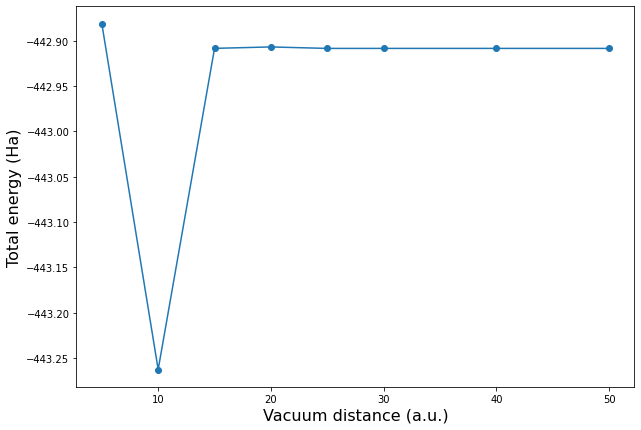

In [56]:
plt.figure(figsize=(10,7))
plt.xlabel('Vacuum distance (a.u.)',size=16)
plt.ylabel('Total energy (Ha)',size=16)
energy = [r.energy for r in results.values()]
plt.plot(c_values,energy)
plt.scatter(c_values,energy)
print(energy)

[0.08753623594732218, 0.34803216172204543, 0.07725834126863818, 0.07774957588055709, 0.07724181625347404, 0.07724240749196931, 0.07724234068386471, 0.07724215167369586]
[0.5360612001252485, 3.8044787110614564, 0.2734887099964898, 0.2930089792649355, 0.27142639570249183, 0.2715852612914983, 0.2714502304586448, 0.2714519742145889]


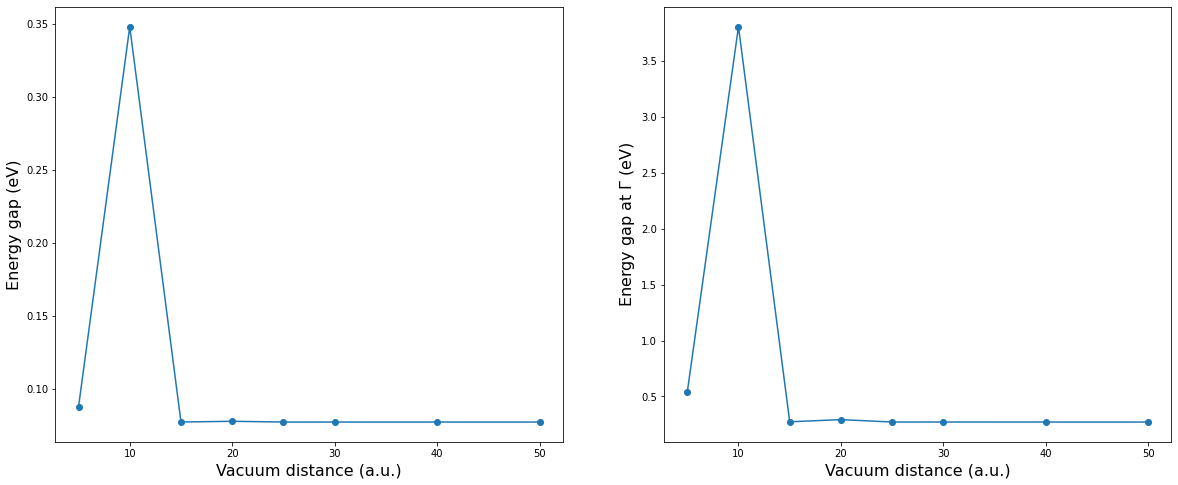

In [59]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20, 8))

ax[0].set_xlabel('Vacuum distance (a.u.)',size=16)
ax[0].set_ylabel('Energy gap (eV)',size=16)
gap = [r.get_gap(verbose=False)['direct_gap'] for r in results.values()]
ax[0].plot(c_values,gap)
ax[0].scatter(c_values,gap)
print(gap)
ax[1].set_xlabel('Vacuum distance (a.u.)',size=16)
ax[1].set_ylabel('Energy gap at $\Gamma$ (eV)',size=16)
gap_gamma = [r.get_evals()[0][28]- r.get_evals()[0][27] for r in results.values()]
ax[1].plot(c_values,gap_gamma)
ax[1].scatter(c_values,gap_gamma)
print(gap_gamma)

On the basis of this analysis we choose c = 25 a.u. as the converged vacuum spacing

### Converged ground states

Finally we perform a last scf calculation with converged parameters

In [28]:
run_dir = 'DFT_analysis'
pseudo_dir = '../pseudos'
Sn_pseudo = 'Sn.rel-pbe-dn-kjpaw_psl.1.0.0.UPF'

alat_conv =  8.83641018 # in a.u. (Bohr)
delta_conv = 0.09148726 # in units of alat
c_conv = 25.0 # vacuum distance in a.u. 

ecut_conv = 80 # energy cutoff on the wavefunction (Ry)
kpoints_conv = [15,15,1]

Sn1 = np.array([0,1./np.sqrt(3.),delta_conv])
Sn2 = np.array([1./2.,1./(2*np.sqrt(3.)),-delta_conv])

inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_num_bnds(30)
inp.set_pseudo_dir(pseudo_dir=pseudo_dir)
inp.set_spinorbit()
inp.add_atom(atom='Sn',pseudo_name=Sn_pseudo,mass=118.71)
inp.set_atoms_number(2)
inp.set_atomic_positions([['Sn',Sn1],['Sn',Sn2]],type='alat')
inp.set_lattice(ibrav=4,celldm1=alat_conv,celldm3=c_conv/alat_conv)
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(type='automatic',points=kpoints_conv)
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'pwscf'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 30,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '1',
  'nat': '2',
  'ibrav': 4,
  'celldm(1)': 8.83641018,
  'celldm(3)': 2.8292032047792515,
  'ecutwfc': 80},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Sn': [118.71, 'Sn.rel-pbe-dn-kjpaw_psl.1.0.0.UPF']},
 'atomic_positions': {'type': 'alat',
  'values': [['Sn', array([0.        , 0.57735027, 0.09148726])],
   ['Sn', array([ 0.5       ,  0.28867513, -0.09148726])]]},
 'kpoints': {'type': 'automatic', 'values': ([15, 15, 1], [0.0, 0.0, 0.0])},
 'cell_parameters': {}}

In [5]:
study = D.Dataset(run_dir=run_dir,num_tasks=1)

idd = 'gs_converged'
inp.set_prefix(D.name_from_id(idd))
study.append_run(id=idd,input=inp,runner=code)    
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 1 parallel tasks


In [6]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
Skip the run of gs_converged
Task [0] ended 
 


In [7]:
results[0].get_gap()

Indirect gap system
Gap : 0.062429814280182905 eV
Direct gap : 0.07724240749196931 eV


{'gap': 0.062429814280182905,
 'direct_gap': 0.07724240749196931,
 'position_cbm': 26,
 'positon_vbm': 0,
 'positon_direct_gap': 26}

Gap at $\Gamma$

In [8]:
results[0].get_evals()[0][28]- results[0].get_evals()[0][27]

0.2715852612914983

## Band structure on high symmetry line

Now we perform the bands computation specifying the kpoints on a path. 

To define the path we write the coordinates of the high symmetry points (using the tpiba_b type of
pw) and we make usage of the function build_kpath

In [29]:
bands_prefix = 'bands'
G = [0.,0.,0.]
Kp = [1./3.,1./np.sqrt(3),0.]
Mp = [0.,1./np.sqrt(3),0.]
high_sym = {'G':G,'K':Kp,'M':Mp} # useful to label the high-sym point on the path

In [30]:
klist = Tools.build_pw_kpath(G,Mp,Kp,G,numstep=60)
klist

[[0.0, 0.0, 0.0, 60],
 [0.0, 0.5773502691896258, 0.0, 60],
 [0.3333333333333333, 0.5773502691896258, 0.0, 60],
 [0.0, 0.0, 0.0, 0]]

In [31]:
inp.set_bands(32,force_symmorphic=True,conv_thr=1e-6)
inp.set_prefix(bands_prefix)
inp.set_kpoints(type='tpiba_b',klist=klist)
inp

{'control': {'calculation': "'bands'",
  'verbosity': "'high'",
  'prefix': "'bands'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 32,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '1',
  'nat': '2',
  'ibrav': 4,
  'celldm(1)': 8.83641018,
  'celldm(3)': 2.8292032047792515,
  'ecutwfc': 80},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Sn': [118.71, 'Sn.rel-pbe-dn-kjpaw_psl.1.0.0.UPF']},
 'atomic_positions': {'type': 'alat',
  'values': [['Sn', array([0.        , 0.57735027, 0.09148726])],
   ['Sn', array([ 0.5       ,  0.28867513, -0.09148726])]]},
 'kpoints': {'type': 'tpiba_b',
  'values': [[0.0, 0.0, 0.0, 60],
   [0.0, 0.5773502691896258, 0.0, 60],
   [0.3333333333333333, 0.5773502691896258, 0.0, 60],
   [0.0, 0.0, 0.0, 0]]},
 'cell_parameters': {}}

In [32]:
results = code.run(input=inp,run_dir=run_dir,name=bands_prefix,source_dir='DFT_analysis/gs_converged.save')

Skip the run of bands
The folder /work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/Xenes/Stanene/DFT_analysis/bands.save already exists. Source_dir DFT_analysis/gs_converged.save not copied


Once that the computation is over we can create an instance of PwBands

In [33]:
bands = U.BandStructure.from_Pw(results,high_sym)

In [34]:
bands.get_high_sym_positions()

(['$\\Gamma$', '$\\Gamma$', 'K', 'M'],
 [0.0, 1.577350265701805, 0.9106835999999988, 0.57735027])

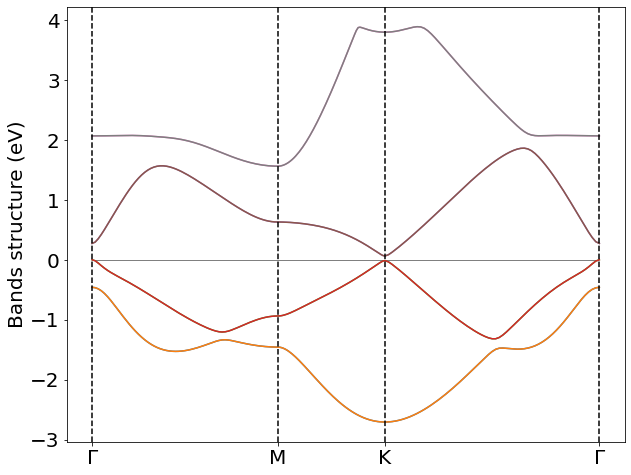

In [35]:
label_size = 20

fig, ax = plt.subplots(figsize=(10, 8))
#ax.set_ylim(-5,7)
bands.plot(plt,selection=[i for i in range(24,32)])
ax.hlines(0.,0.,1.57,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)

#plt.savefig(fname='Plot/band_structure.eps',format='eps',bbox_inches = "tight")

We perform a zoom on the valence and conduction bands

(-1.0, 1.0)

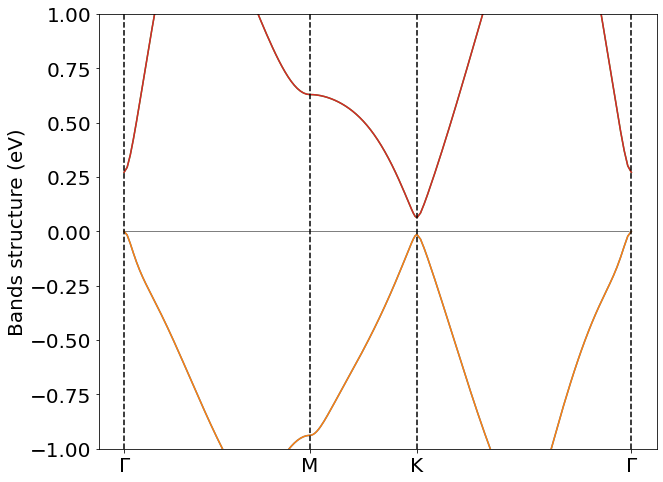

In [36]:
label_size = 20

fig, ax = plt.subplots(figsize=(10, 8))
#ax.set_ylim(-5,7)
bands.plot(plt,selection=[i for i in range(26,30)])
ax.hlines(0.,0.,1.57,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_ylim(-1,1)

#plt.savefig(fname='Plot/band_structure.eps',format='eps',bbox_inches = "tight")

## NSCF computations on regular grids

We set up the nscf computations on regular grids.

In agreement with the input provided by Fulvio Paleari we use  a 42x42x1 k-poinst sampling and 250 empty bands.

In [40]:
Gamma = np.array([0.,0.])
K = np.array([2./3.,0])
M = np.array([1./2.,1./(2*np.sqrt(3))])
Kp = np.array([1./3.,1./np.sqrt(3)])
Mp = np.array([0.,1./np.sqrt(3)])

In [41]:
nbnds = 500 #30
inp.set_nscf(nbnds,force_symmorphic=True,conv_thr=1e-6)
inp

{'control': {'calculation': "'nscf'",
  'verbosity': "'high'",
  'prefix': "'bands'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 500,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '1',
  'nat': '2',
  'ibrav': 4,
  'celldm(1)': 8.83641018,
  'celldm(3)': 2.8292032047792515,
  'ecutwfc': 80},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Sn': [118.71, 'Sn.rel-pbe-dn-kjpaw_psl.1.0.0.UPF']},
 'atomic_positions': {'type': 'alat',
  'values': [['Sn', array([0.        , 0.57735027, 0.09148726])],
   ['Sn', array([ 0.5       ,  0.28867513, -0.09148726])]]},
 'kpoints': {'type': 'tpiba_b',
  'values': [[0.0, 0.0, 0.0, 60],
   [0.0, 0.5773502691896258, 0.0, 60],
   [0.3333333333333333, 0.5773502691896258, 0.0, 60],
   [0.0, 0.0, 0.0, 0]]},
 'cell_parameters': {}}

In [42]:
kvalues = [30] #[18,30,42,60,72]

In [43]:
study = D.Dataset(run_dir=run_dir,num_tasks=2)
study.set_postprocessing_function(PP.pw_parse_data)

for k in kvalues:
    idd = {'kpoints':k,'nbnds':nbnds}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_kpoints(points=[k,k,1])
    study.append_run(id=idd,input=inp,runner=code,source_dir='DFT_analysis/gs_converged.save')

Initialize a Dataset with 2 parallel tasks


In [44]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'DFT_analysis',
 'num_tasks': 2,
 'verbose': True,
 'input': {'control': {'calculation': "'nscf'",
   'verbosity': "'high'",
   'prefix': "'kpoints_30-nbnds_500'",
   'outdir': "'./'",
   'pseudo_dir': "'../pseudos'"},
  'system': {'force_symmorphic': '.true.',
   'nbnd': 500,
   'lspinorb': '.true.',
   'noncolin': '.true.',
   'ntyp': '1',
   'nat': '2',
   'ibrav': 4,
   'celldm(1)': 8.83641018,
   'celldm(3)': 2.8292032047792515,
   'ecutwfc': 80},
  'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
  'ions': {},
  'cell': {},
  'atomic_species': {'Sn': [118.71, 'Sn.rel-pbe-dn-kjpaw_psl.1.0.0.UPF']},
  'atomic_positions': {'type': 'alat',
   'values': [['Sn', array([0.        , 0.57735027, 0.09148726])],
    ['Sn', array([ 0.5       ,  0.28867513, -0.09148726])]]},
  'kpoints': {'type': 'automatic', 'values': ([30, 30, 1], [0.0, 0.0, 0.0])},
  'cell_parameters': {}},
 'source_dir': 'DFT_analysis/gs_converged.save',
 'name': 'kpoints_30-

In [45]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
Skip the run of kpoints_30-nbnds_500
The folder /work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/Xenes/Stanene/DFT_analysis/kpoints_30-nbnds_500.save already exists. Source_dir DFT_analysis/gs_converged.save not copied
Task [0] ended 
 


In [47]:
results[0].get_gap()

Indirect gap system
Gap : 0.06293570107691293 eV
Direct gap : 0.07722606063751525 eV


{'gap': 0.06293570107691293,
 'direct_gap': 0.07722606063751525,
 'position_cbm': 90,
 'positon_vbm': 0,
 'positon_direct_gap': 90}

In [14]:
kp = results[4].kpoints # cartesian coordinates in units of 2\pi/alat

number of kpoints = 469


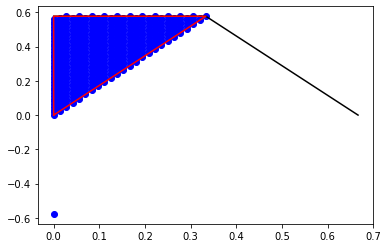

In [15]:
BZ = [K, Kp, Mp]
print('number of kpoints = %s'%len(kp))
plt.plot(*np.column_stack(BZ),color='black')
IBZ = [Gamma,Kp, Mp,Gamma]
plt.plot(*np.column_stack(IBZ),color='red')
plt.scatter(kp[:,0],kp[:,1],c='blue')